In [ ]:
!pip install vaderSentiment
from pprint import pprint
import os
import sys
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib.pyplot import figure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# configuration
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
datadir = '/kaggle/input/CORD-19-research-challenge'
# datadir = 'kaggle/input/CORD-19-research-challenge' # for local test
metadata = 'metadata.csv'
subsetdata = ['biorxiv_medrxiv', 'comm_use_subset', 'noncomm_use_subset', 'custom_license']
covid19_dataset_path = 'covid19_datasets'

# Motivation for the project

One of the most pressing challenges related to COVID-19 is finding effective treatments. Since the virus has began spreading, numerous papers have been published regarding different treatment options.  

In this project, we have created a sentiment model that takes in the names of popular COVID-19 treatments and returns the sentiment of different papers that are about these treatments. 

We used the VADER sentiment model to test the polarity of each paper. Each paper’s sentiment is scored from -1 to +1. 

# covid_19 tools

In [ ]:
# Useful functions and constants from
# https://www.kaggle.com/ajrwhite/covid-19-thematic-tagging-with-regular-expressions/notebook
# Fix DOI links
def doi_url(d):
    if d.startswith('http'):
        return d
    elif d.startswith('doi.org'):
        return f'http://{d}'
    else:
        return f'http://doi.org/{d}'
    
# Turn authors list into '<surname>' or '<surname> et al'
def shorten_authors(authors):
    if isinstance(authors, str):
        authors = authors.split(';')
        if len(authors) == 1:
            return authors[0].split(',')[0]
        else:
            return f'{authors[0].split(",")[0]} et al'
    else:
        return authors

def load_metadata(metadata_file):
    df = pd.read_csv(metadata_file,
                 dtype={'Microsoft Academic Paper ID': str,
                        'pubmed_id': str},
                 low_memory=False)
    df.doi = df.doi.fillna('').apply(doi_url)
    df['authors_short'] = df.authors.apply(shorten_authors)
    df['sorting_date'] = pd.to_datetime(df.publish_time)
    print(f'loaded DataFrame with {len(df)} records')
    return df.sort_values('sorting_date', ascending=False)

def abstract_title_filter(df, search_string):
    return (df.abstract.str.lower().str.replace('-', ' ')
            .str.contains(search_string, na=False) |
            df.title.str.lower().str.replace('-', ' ')
            .str.contains(search_string, na=False))

# Helper function which counts synonyms and adds tag column to DF
def count_and_tag(df: pd.DataFrame,
                  synonym_list: list,
                  tag_suffix: str) -> (pd.DataFrame, pd.Series):
    counts = {}
    df[f'tag_{tag_suffix}'] = False
    for s in synonym_list:
        synonym_filter = abstract_title_filter(df, s)
        counts[s] = sum(synonym_filter)
        df.loc[synonym_filter, f'tag_{tag_suffix}'] = True
    print(f'Added tag_{tag_suffix} to DataFrame')
    return df, pd.Series(counts)

# Function for printing out key passage of abstract based on key terms
def print_key_phrases(df, key_terms, n=5, chars=300):
    for ind, item in enumerate(df[:n].itertuples()):
        print(f'{ind+1} of {len(df)}')
        print(item.title)
        print('[ ' + item.doi + ' ]')
        try:
            i = len(item.abstract)
            for kt in key_terms:
                kt = kt.replace(r'\b', '')
                term_loc = item.abstract.lower().find(kt)
                if term_loc != -1:
                    i = min(i, term_loc)
            if i < len(item.abstract):
                print('    "' + item.abstract[i-30:i+chars-30] + '"')
            else:
                print('    "' + item.abstract[:chars] + '"')
        except:
            print('NO ABSTRACT')
        print('---')
        
def add_tag_covid19(df):
    # Customised approach to include more complicated logic
    df, covid19_counts = count_and_tag(df, COVID19_SYNONYMS, 'disease_covid19')
    novel_corona_filter = (abstract_title_filter(df, 'novel corona') &
                           df.publish_time.str.startswith('2020', na=False))
    df.loc[novel_corona_filter, 'tag_disease_covid19'] = True
    covid19_counts = covid19_counts.append(pd.Series(index=['novel corona'],
                                                     data=[novel_corona_filter.sum()]))
    return df, covid19_counts


def load_full_text(df, data_folder):
    json_list = []
    # Adding code to handle PDF vs. XML parse
    for row in df[df.has_pdf_parse].itertuples():
        filename = f'{row.sha}.json'
        sources = ['biorxiv_medrxiv', 'comm_use_subset',
                   'custom_license', 'noncomm_use_subset']
        for source in sources:
            if filename in os.listdir(os.path.join(data_folder, source, source, 'pdf_json')):
                with open(os.path.join(data_folder, source, source, 'pdf_json', filename), 'rb') as f:
                    json_list.append(json.load(f))
    for row in df[df.has_pmc_xml_parse].itertuples():
        filename = f'{row.sha}.json'
        sources = ['comm_use_subset',
                   'custom_license', 'noncomm_use_subset']
        for source in sources:
            if filename in os.listdir(os.path.join(data_folder, source, source, 'pmc_json')):
                with open(os.path.join(data_folder, source, source, 'pmc_json', filename), 'rb') as f:
                    json_list.append(json.load(f))
    print(f'Found {len(json_list)} full texts for {len(df)} records')
    return json_list


def display_dataframe(df, title):
    text = f'<h2>{title}</h2><table><tr>'
    text += ''.join([f'<td><b>{col}</b></td>' for col in df.columns.values]) + '</tr>'
    for row in df.itertuples():
        text +=  '<tr>' + ''.join([f'<td valign="top">{v}</td>' for v in row[1:]]) + '</tr>'
    text += '</table>'
    display(HTML(text))
    

# CONSTANTS

COVID19_SYNONYMS = [
                    'covid',
                    'coronavirus disease 19',
                    'sars cov 2', # Note that search function replaces '-' with ' '
                    '2019 ncov',
                    '2019ncov',
                    r'2019 n cov\b',
                    r'2019n cov\b',
                    'ncov 2019',
                    r'\bn cov 2019',
                    'coronavirus 2019',
                    'wuhan pneumonia',
                    'wuhan virus',
                    'wuhan coronavirus',
                    r'coronavirus 2\b'
]

AGE_SYNONYMS = ['median age',
                'mean age',
                'average age',
                'elderly',
                r'\baged\b',
                r'\bold',
                'young',
                'teenager',
                'adult',
                'child'
               ]

SEX_SYNONYMS = ['sex',
                'gender',
                r'\bmale\b',
                r'\bfemale\b',
                r'\bmales\b',
                r'\bfemales\b',
                r'\bmen\b',
                r'\bwomen\b'
               ]

BODYWEIGHT_SYNONYMS = [
    'overweight',
    'over weight',
    'obese',
    'obesity',
    'bodyweight',
    'body weight',
    r'\bbmi\b',
    'body mass',
    'body fat',
    'bodyfat',
    'kilograms',
    r'\bkg\b', # e.g. 70 kg
    r'\dkg\b'  # e.g. 70kg
]

SMOKING_SYNONYMS = ['smoking',
                    'smoke',
                    'cigar', # this picks up cigar, cigarette, e-cigarette, etc.
                    'nicotine',
                    'cannabis',
                    'marijuana']

DIABETES_SYNONYMS = [
    'diabet', # picks up diabetes, diabetic, etc.
    'insulin', # any paper mentioning insulin likely to be relevant
    'blood sugar',
    'blood glucose',
    'ketoacidosis',
    'hyperglycemi', # picks up hyperglycemia and hyperglycemic
]

HYPERTENSION_SYNONYMS = [
    'hypertension',
    'blood pressure',
    r'\bhbp\b', # HBP = high blood pressure
    r'\bhtn\b' # HTN = hypertension
]

IMMUNODEFICIENCY_SYNONYMS = [
    'immune deficiency',
    'immunodeficiency',
    r'\bhiv\b',
    r'\baids\b'
    'granulocyte deficiency',
    'hypogammaglobulinemia',
    'asplenia',
    'dysfunction of the spleen',
    'spleen dysfunction',
    'complement deficiency',
    'neutropenia',
    'neutropaenia', # alternate spelling
    'cell deficiency' # e.g. T cell deficiency, B cell deficiency
]

CANCER_SYNONYMS = [
    'cancer',
    'malignant tumour',
    'malignant tumor',
    'melanoma',
    'leukemia',
    'leukaemia',
    'chemotherapy',
    'radiotherapy',
    'radiation therapy',
    'lymphoma',
    'sarcoma',
    'carcinoma',
    'blastoma',
    'oncolog'
]

CHRONICRESP_SYNONYMS = [
    'chronic respiratory disease',
    'asthma',
    'chronic obstructive pulmonary disease',
    r'\bcopd',
    'chronic bronchitis',
    'emphysema'
]

IMMUNITY_SYNONYMS = [
    'immunity',
    r'\bvaccin',
    'innoculat'
]

CLIMATE_SYNONYMS = [
    'climate',
    'weather',
    'humid',
    'sunlight',
    'air temperature',
    'meteorolog', # picks up meteorology, meteorological, meteorologist
    'climatolog', # as above
    'dry environment',
    'damp environment',
    'moist environment',
    'wet environment',
    'hot environment',
    'cold environment',
    'cool environment'
]

TRANSMISSION_SYNONYMS = [
    'transmiss', # Picks up 'transmission' and 'transmissibility'
    'transmitted',
    'incubation',
    'environmental stability',
    'airborne',
    'via contact',
    'human to human',
    'through droplets',
    'through secretions',
    r'\broute',
    'exportation'
]

REPR_SYNONYMS = [
    r'reproduction \(r\)',
    'reproduction rate',
    'reproductive rate',
    '{r}_0',
    r'\br0\b',
    r'\br_0',
    '{r_0}',
    r'\b{r}',
    r'\br naught',
    r'\br zero'
]

INCUBATION_SYNONYMS = [
    'incubation period',
    'period of incubation',
    'latent period',
    'latency period',
    'period of latency',
    'window period'
]

PERSISTENCE_SYNONYMS = ['persistence',
                        # r'(?<!viral )surface[s]?\b', # THIS DOESN'T WORK
                        'survival surface',
                        'persistence surface',
                        'survival on a surface',
                        'persistence on a surface',
                        'carrier test',
                        'suspension test',
                        'fomite',
                        # 'survival time',
                        'environmental surface',
                        'environmental stability',
                        'environmental reservoirs',
                        'environmental survival',
                        'pathogens in the environment',
                        'environmental pathogen',
                        'contaminated',
                        'contamination',
                        'surface stability',
                        'surface swab',
                        'inanimate surface',
                        'surface disinfection'
                       ]

# filtering papers specific to COVID-19

In [ ]:
# df = pd.read_csv("data/metadata.csv")
df = pd.read_csv(f'{datadir}/{metadata}', na_filter= False)
corona, covid19_counts = count_and_tag(df, COVID19_SYNONYMS, 'disease_covid19')
df

In [ ]:
corona_filtered = corona[corona.loc[:,"tag_disease_covid19"] == True]
corona_filtered

In [ ]:
covid19_counts.sort_values(ascending=False)

# adding popular COVID-19 treatments

In [ ]:
treatment_names = [
'remdesivir',
'kaletra',
'actemra',
'kevzara',
'convalescent plasma',
'avigan',
'favilavir',
'tjm2',
'medicago',
'at-100',
'tzls-501',
'oya1',
'bpi-002',
'ino-4800',
'np-120',
'ifenprodil',
'mrna-1273',
'brilacidin',
'bcx4430',
'regn3048',
'regn3051',
'interferon-β',
'oseltamivir phosphate',
'tamiflu',
'zanamivir',
'relenza',
'peramivir',
'rapivab',
'baloxavir marboxil',
'xofluza']

# filtering papers that mention the COVID-19 treatments

In [ ]:
treatments, treatments_counts = count_and_tag(corona_filtered, treatment_names, 'treatments_covid19')

In [ ]:
treatments_filtered = treatments[treatments.loc[:,"tag_treatments_covid19"] == True]
treatments_filtered2 = treatments_filtered[treatments_filtered['abstract'].notna()]
# titles = treatments_filtered.loc[:,"title"]
titles = treatments_filtered2.loc[:,"abstract"]

# initializing VADER sentiment model, adding sentiment scores based on title and abstract

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
treatments_filtered2["scores"] = treatments_filtered2["abstract"].apply(lambda review: sid.polarity_scores(review))
treatments_filtered2["compound"] = treatments_filtered2["scores"].apply(lambda d:d["compound"])
treatments_filtered2["comp_score"] = treatments_filtered2["compound"].apply(lambda score: 'pos' if  score >=0 else 'neg')

In [ ]:
treatments_filtered2

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# scanning the abstracts and displaying the treatments that were in the papers with the highest compound polarity score

In [ ]:
abstracts = treatments_filtered2.sort_values("compound", ascending = False).loc[:,"abstract"]
for ab in abstracts:
    found_words = []
    for word in treatment_names:
        if word in ab:
            found_words.append(word)
    print(found_words)

### Number of positive/negative papers

In [ ]:
bars = treatments_filtered2.loc[:,"comp_score"]
pos_height = len(treatments_filtered2[treatments_filtered2.loc[:,"comp_score"] == "pos"])
neg_height = len(treatments_filtered2[treatments_filtered2.loc[:,"comp_score"] == "neg"])
plt.bar(["positive", "negative"], [pos_height, neg_height])
# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Number of papers')
plt.yticks(np.arange(0,22, 2))
plt.xlabel('Sentiment')
plt.title('Sentiment of papers related to COVID-19')

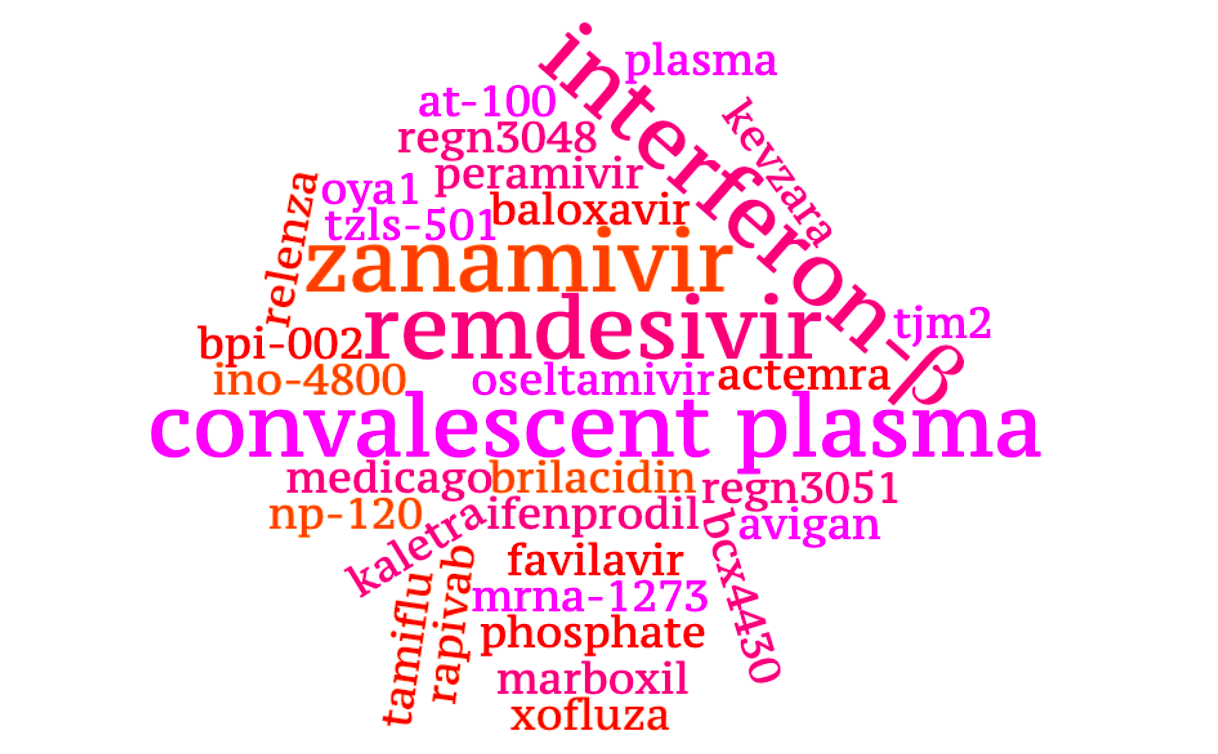

### compound score of papers

In [ ]:
paper_numbers = treatments_filtered2.index
x = np.array(paper_numbers)
paper_numbers_string = []
for i in x:
    paper_numbers_string.append(str(i))
scores = treatments_filtered2.loc[:,"compound"]
figure(figsize=(40,10))
plt.bar(paper_numbers_string, scores)
plt.ylabel('Compound Sentiment Score')
plt.xlabel('Paper number')
plt.title('compound score of papers')

# Conclusion:

The goal of our project was to scan through research papers on potential treatments for the COVID-19 outbreak and check the viability of the treatments via sentiment analysis on the tone of the paper to conclude whether it succeeded or failed. We had a wide range of outputs across the abstracts of the research papers, going from about -0.95 to 0.95 (-1 to 0 being a negative sentiment and 0-1 being a positive sentiment). The treatments we found to have a positive sentiment were remdesivir, convalescent plasma, interferon-β, and zanamivir. In action, our program can be utilized in the process of scanning future documents in a large scale for potential treatments for this crisis. 


# Extensions: 

Our document-search for treatment terms and sentiment analysis was only based upon the abstracts of the lab-reports. Incorporating the full-body text as further research could uncover slightly different results and a deeper classification of whether the treatment discussed was effective or not. Another factor for further experimentation is a greater concentration of documents discussing treatments for more results. We also only used the metadata.csv in order to accomplish our task and perhaps could have included some other datasets (non_comm_use, etc.) to get more data.  